In [1]:
import argparse
import os
from functools import partial

import numpy as np
import pandas as pd
import torch
import yaml
from taggle.engine import (
    CSVLoggerExtension,
    LineNotifyExtension,
    TensorBoardExtension
)
from taggle.losses import get_losses_dict
# from taggle.models import ModelProvider
from taggle.models.sync_batchnorm import convert_model
from taggle.optimizers import get_optimizer
from taggle.utils import stratified_kfold_cross_validator
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    ReduceLROnPlateau,
    StepLR
)
from torch.utils.data import DataLoader

from dataset import dataset_zoo
from engines import engine_zoo
from models import BirdSongModelProvider

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
config_name = "resnest50f_adacos"
config_path = os.path.join("config", config_name + '.yaml')
print(f"config_path:{config_path}")
with open(config_path, "r+") as f:
    config = yaml.load(f)
    
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

config_path:config/resnest50f_adacos.yaml


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [3]:
model_provider = BirdSongModelProvider()
model_config = """
backbone: 
    type: resnest50_fast_1s1x64d
    params:
        backbone_weights: imagenet
heads:
    output1: 
        type: SimpleHead
        params:
            num_class: 264
            pooling: GeM
            metric_branch: true
            extract_feature: true
mid_activation: ReLU
"""
config["model"] = yaml.load(model_config)
model = model_provider.get_model(config["model"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [4]:
fold = 0
csv_dir = os.path.join(config["logdir"], 'csvs')
train_df = pd.read_csv(os.path.join(csv_dir, f'train_fold{fold}.csv'))
valid_df = pd.read_csv(os.path.join(csv_dir, f'valid_fold{fold}.csv'))
w = torch.load(config["logdir"] + '/fold' + str(fold) + '/checkpoints/best_f1.pth')["default_model_state_dict"]
model.load_state_dict(w)
Dataset = dataset_zoo[config["dataset"]["type"]]
train_dataset = Dataset(df=train_df,
                        mode="train",
                        **config["dataset"]["params"])
valid_dataset = Dataset(df=valid_df,
                        mode="valid",
                        **config["dataset"]["params"])
train_loader = DataLoader(train_dataset,
                          batch_size=config["batchsize"],
                          shuffle=False,
                          num_workers=config["num_workers"],
                          drop_last=False,
                          worker_init_fn=worker_init_fn,
                          pin_memory=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=config["batchsize"],
                          shuffle=False,
                          num_workers=config["num_workers"],
                          drop_last=False,
                          worker_init_fn=worker_init_fn,
                          pin_memory=True)
Engine = engine_zoo[config["engine"]["type"]]


In [5]:
engine = Engine(
    models=model,
    optimizers=None,
    schedulers=None,
    criterions=None,
    output_dir=os.path.join(config["logdir"], f"fold{fold}"),
    train_loader=train_loader,
    valid_loader=train_loader,
    **config["engine"]["params"]
)
train_output = engine.test()

Epoch 0 Test: 100%|##########| 267/267 [07:46<00:00,  1.75s/it]


In [6]:
engine = Engine(
    models=model,
    optimizers=None,
    schedulers= None,
    criterions=None,
    output_dir=os.path.join(config["logdir"], f"fold{fold}"),
    train_loader=valid_loader,
    valid_loader=valid_loader,
    **config["engine"]["params"]
)
valid_output = engine.test()

Epoch 0 Test: 100%|##########| 68/68 [01:53<00:00,  1.67s/it]


In [7]:
print(train_output["output1"].shape, valid_output["output1"].shape)

(17057, 1024) (4318, 1024)


In [10]:
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

In [11]:
train_labels = np.vectorize(lambda x: BIRD_CODE[x])(train_df.ebird_code.values)
valid_labels = np.vectorize(lambda x: BIRD_CODE[x])(valid_df.ebird_code.values)

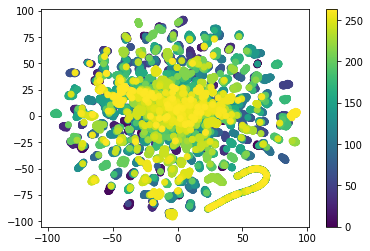

In [19]:
from sklearn.manifold import TSNE
train_reduce = TSNE(n_components=2, random_state=0).fit_transform(train_output["output1"])
valid_reduce = TSNE(n_components=2, random_state=0).fit_transform(valid_output["output1"])

import matplotlib.pyplot as plt
plt.scatter(train_reduce[:, 0], train_reduce[:, 1], c=train_labels)
plt.colorbar()

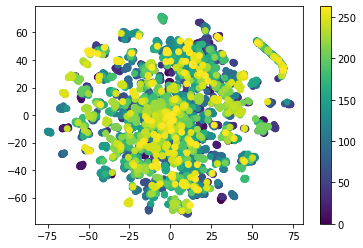

In [21]:
plt.scatter(valid_reduce[:, 0], valid_reduce[:, 1], c=valid_labels)
plt.colorbar()